In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff

from model import FixCapsNet

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"#"COVID-19"#"ISIC2019"#"skin_lesion"#
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}
# write = SummaryWriter()
#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [4]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((308,308)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets","HAM10000")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [5]:
BatchSize = 168#128#168
V_size = 31 #30#64
T_size = 31 
train_doc = "train525e384"
val_doc = "val525png384"
test_doc = "test525png384"
learning_rate = 0.123
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.


In [6]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 140, 140]         169,472
              ReLU-2        [-1, 128, 140, 140]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps",model=network,inputes=input_data)
#FixCaps-DS:FLOPs(G)--> 0.07(0.08). FPS:132

  Model | Params(M) | FLOPs(G) | FPS
--------|-----------|----------|-----
FixCaps |    0.30   |   3.33   | 123.6


In [8]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(21, 21), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [9]:
# def_betas=(0.9, 0.999)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)
# optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
#base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0,
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [10]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    # scaler = torch.cuda.amp.GradScaler()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        # data, target =data.to(device), target_one_hot.to(device)
        # with torch.cuda.amp.autocast():
        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()        
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()#AdamW            
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [11]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [12]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0626_230159
./tmp/HAM10000/0626_230159/best_HAM10000_0626_230159.pth


In [13]:
num_epochs = 150

In [14]:
# network.load_state_dict(torch.load(last_path))
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.37773,ACC:0.32433
[308/308] Loss0.33731,ACC:0.37753
Train Epoch:[1] Loss:0.40288,Acc:0.37825,Best_train:0.37825
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:55.666%
Best_val:[55.666%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.33569,ACC:0.47275
[308/308] Loss0.31058,ACC:0.48176
Train Epoch:[2] Loss:0.34024,Acc:0.48267,Best_train:0.48267
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:59.94%
Best_val:[59.94%]
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30685,ACC:0.51364
[308/308] Loss0.29381,ACC:0.52037
Train Epoch:[3] Loss:0.31657,Acc:0.52136,Best_train:0.52136
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:68.588%
Best_val:[68.588%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29042,ACC:0.54592
[308/308] Loss0.30550,ACC:0.54497
Train Epoch:[4] Loss:0.30072,Acc:0.54601,Best_train:0.54601
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:70.477%
Best_val:[70.477%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28091,ACC:0.55651
[308/308] Loss0.31152,ACC:0.55674
Train Epoch:[5] Loss:0.29280,Acc:0.55780,Best_train:0.55780
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.962%
Best_val:[72.962%]
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26535,ACC:0.56544
[308/308] Loss0.30061,ACC:0.56217
Train Epoch:[6] Loss:0.29043,Acc:0.56324,Best_train:0.56324
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.658%
Best_val:[73.658%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27771,ACC:0.56459
[308/308] Loss0.26319,ACC:0.56200
Train Epoch:[7] Loss:0.28990,Acc:0.56306,Best_train:0.56324
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:74.95%
Best_val:[74.95%]
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26950,ACC:0.56064
[308/308] Loss0.29627,ACC:0.56196
Train Epoch:[8] Loss:0.29077,Acc:0.56303,Best_train:0.56324
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.863%
Best_val:[74.95%]
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25190,ACC:0.56327
[308/308] Loss0.32191,ACC:0.56495
Train Epoch:[9] Loss:0.29051,Acc:0.56603,Best_train:0.56603
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:70.577%
Best_val:[74.95%]
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27533,ACC:0.56416
[308/308] Loss0.26797,ACC:0.56623
Train Epoch:[10] Loss:0.28740,Acc:0.56730,Best_train:0.56730
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.068%
Best_val:[74.95%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26852,ACC:0.58612
[308/308] Loss0.30303,ACC:0.58281
Train Epoch:[11] Loss:0.27954,Acc:0.58392,Best_train:0.58392
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.143%
Best_val:[76.143%]
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28091,ACC:0.59740
[308/308] Loss0.33023,ACC:0.60003
Train Epoch:[12] Loss:0.27021,Acc:0.60117,Best_train:0.60117
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.92%
Best_val:[79.92%]
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25306,ACC:0.61565
[308/308] Loss0.27858,ACC:0.61472
Train Epoch:[13] Loss:0.26143,Acc:0.61589,Best_train:0.61589
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.324%
Best_val:[79.92%]
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27142,ACC:0.63049
[308/308] Loss0.23915,ACC:0.63234
Train Epoch:[14] Loss:0.25180,Acc:0.63354,Best_train:0.63354
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.026%
Best_val:[79.92%]
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24215,ACC:0.64413
[308/308] Loss0.24466,ACC:0.64232
Train Epoch:[15] Loss:0.24570,Acc:0.64353,Best_train:0.64353
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.565%
Best_val:[79.92%]
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22336,ACC:0.65124
[308/308] Loss0.24641,ACC:0.64653
Train Epoch:[16] Loss:0.24345,Acc:0.64776,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.143%
Best_val:[79.92%]
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21266,ACC:0.64738
[308/308] Loss0.26460,ACC:0.64554
Train Epoch:[17] Loss:0.24337,Acc:0.64677,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.044%
Best_val:[79.92%]
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23872,ACC:0.63891
[308/308] Loss0.27348,ACC:0.63942
Train Epoch:[18] Loss:0.24789,Acc:0.64063,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.664%
Best_val:[79.92%]
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25518,ACC:0.63401
[308/308] Loss0.22348,ACC:0.63358
Train Epoch:[19] Loss:0.25062,Acc:0.63478,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:69.881%
Best_val:[79.92%]
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25871,ACC:0.62825
[308/308] Loss0.25289,ACC:0.63395
Train Epoch:[20] Loss:0.25224,Acc:0.63515,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:69.583%
Best_val:[79.92%]
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27051,ACC:0.63316
[308/308] Loss0.19195,ACC:0.63476
Train Epoch:[21] Loss:0.25084,Acc:0.63596,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:71.769%
Best_val:[79.92%]
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25607,ACC:0.64286
[308/308] Loss0.24240,ACC:0.64394
Train Epoch:[22] Loss:0.24509,Acc:0.64516,Best_train:0.64776
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.547%
Best_val:[79.92%]
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23413,ACC:0.65785
[308/308] Loss0.23633,ACC:0.65642
Train Epoch:[23] Loss:0.23804,Acc:0.65767,Best_train:0.65767
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:69.98%
Best_val:[79.92%]
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24850,ACC:0.66419
[308/308] Loss0.24595,ACC:0.66734
Train Epoch:[24] Loss:0.23086,Acc:0.66861,Best_train:0.66861
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[82.803%]
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20629,ACC:0.67761
[308/308] Loss0.26255,ACC:0.67697
Train Epoch:[25] Loss:0.22587,Acc:0.67825,Best_train:0.67825
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.038%
Best_val:[82.803%]
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20267,ACC:0.67938
[308/308] Loss0.20748,ACC:0.67944
Train Epoch:[26] Loss:0.22442,Acc:0.68073,Best_train:0.68073
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[82.803%]
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21604,ACC:0.68166
[308/308] Loss0.19878,ACC:0.68112
Train Epoch:[27] Loss:0.22398,Acc:0.68241,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.237%
Best_val:[82.803%]
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23285,ACC:0.67606
[308/308] Loss0.30285,ACC:0.67345
Train Epoch:[28] Loss:0.22951,Acc:0.67473,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.938%
Best_val:[82.803%]
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23015,ACC:0.66674
[308/308] Loss0.25879,ACC:0.66439
Train Epoch:[29] Loss:0.23363,Acc:0.66565,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.523%
Best_val:[82.803%]
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23600,ACC:0.66180
[308/308] Loss0.26395,ACC:0.66147
Train Epoch:[30] Loss:0.23448,Acc:0.66272,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[82.803%]
[Train Epoch:[31]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24902,ACC:0.66593
[308/308] Loss0.21370,ACC:0.66613
Train Epoch:[31] Loss:0.23442,Acc:0.66739,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[83.4%]
[Train Epoch:[32]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22003,ACC:0.66597
[308/308] Loss0.20344,ACC:0.66837
Train Epoch:[32] Loss:0.23114,Acc:0.66964,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.417%
Best_val:[83.4%]
[Train Epoch:[33]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21111,ACC:0.67973
[308/308] Loss0.21911,ACC:0.67977
Train Epoch:[33] Loss:0.22442,Acc:0.68106,Best_train:0.68241
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.231%
Best_val:[83.4%]
[Train Epoch:[34]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21364,ACC:0.68680
[308/308] Loss0.22731,ACC:0.68899
Train Epoch:[34] Loss:0.21908,Acc:0.69030,Best_train:0.69030
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:70.577%
Best_val:[83.4%]
[Train Epoch:[35]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21171,ACC:0.69770
[308/308] Loss0.24616,ACC:0.69647
Train Epoch:[35] Loss:0.21479,Acc:0.69779,Best_train:0.69779
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.032%
Best_val:[83.4%]
[Train Epoch:[36]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18835,ACC:0.70234
[308/308] Loss0.23361,ACC:0.69923
Train Epoch:[36] Loss:0.21352,Acc:0.70056,Best_train:0.70056
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:74.354%
Best_val:[83.4%]
[Train Epoch:[37]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20377,ACC:0.69705
[308/308] Loss0.21175,ACC:0.69985
Train Epoch:[37] Loss:0.21375,Acc:0.70118,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[83.4%]
[Train Epoch:[38]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19999,ACC:0.69685
[308/308] Loss0.21395,ACC:0.69312
Train Epoch:[38] Loss:0.21715,Acc:0.69444,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.559%
Best_val:[83.4%]
[Train Epoch:[39]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23837,ACC:0.68097
[308/308] Loss0.28674,ACC:0.68555
Train Epoch:[39] Loss:0.22210,Acc:0.68685,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.219%
Best_val:[83.4%]
[Train Epoch:[40]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22588,ACC:0.67509
[308/308] Loss0.29987,ACC:0.67898
Train Epoch:[40] Loss:0.22620,Acc:0.68027,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.412%
Best_val:[83.4%]
[Train Epoch:[41]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21976,ACC:0.67567
[308/308] Loss0.20365,ACC:0.68184
Train Epoch:[41] Loss:0.22590,Acc:0.68313,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.412%
Best_val:[83.4%]
[Train Epoch:[42]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20657,ACC:0.68994
[308/308] Loss0.27063,ACC:0.68825
Train Epoch:[42] Loss:0.22229,Acc:0.68956,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:63.916%
Best_val:[83.4%]
[Train Epoch:[43]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24081,ACC:0.69844
[308/308] Loss0.24055,ACC:0.69610
Train Epoch:[43] Loss:0.21643,Acc:0.69742,Best_train:0.70118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.149%
Best_val:[83.4%]
[Train Epoch:[44]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20772,ACC:0.70543
[308/308] Loss0.21725,ACC:0.70441
Train Epoch:[44] Loss:0.21103,Acc:0.70575,Best_train:0.70575
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.435%
Best_val:[83.4%]
[Train Epoch:[45]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16942,ACC:0.71030
[308/308] Loss0.17302,ACC:0.70974
Train Epoch:[45] Loss:0.20667,Acc:0.71109,Best_train:0.71109
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.728%
Best_val:[83.4%]
[Train Epoch:[46]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24348,ACC:0.71119
[308/308] Loss0.17764,ACC:0.71218
Train Epoch:[46] Loss:0.20602,Acc:0.71353,Best_train:0.71353
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.447%
Best_val:[83.4%]
[Train Epoch:[47]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19403,ACC:0.71603
[308/308] Loss0.22284,ACC:0.71432
Train Epoch:[47] Loss:0.20579,Acc:0.71568,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[83.4%]
[Train Epoch:[48]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21486,ACC:0.70257
[308/308] Loss0.21840,ACC:0.70574
Train Epoch:[48] Loss:0.21040,Acc:0.70708,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[83.4%]
[Train Epoch:[49]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21471,ACC:0.70632
[308/308] Loss0.18762,ACC:0.70325
Train Epoch:[49] Loss:0.21325,Acc:0.70459,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.833%
Best_val:[83.4%]
[Train Epoch:[50]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22970,ACC:0.69983
[308/308] Loss0.23744,ACC:0.69763
Train Epoch:[50] Loss:0.21742,Acc:0.69895,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:69.384%
Best_val:[83.4%]
[Train Epoch:[51]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18703,ACC:0.69917
[308/308] Loss0.22864,ACC:0.69569
Train Epoch:[51] Loss:0.21742,Acc:0.69701,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.845%
Best_val:[83.4%]
[Train Epoch:[52]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21990,ACC:0.69790
[308/308] Loss0.21176,ACC:0.69761
Train Epoch:[52] Loss:0.21564,Acc:0.69893,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[83.4%]
[Train Epoch:[53]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20300,ACC:0.70489
[308/308] Loss0.17734,ACC:0.70656
Train Epoch:[53] Loss:0.21091,Acc:0.70790,Best_train:0.71568
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.734%
Best_val:[83.4%]
[Train Epoch:[54]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19087,ACC:0.72163
[308/308] Loss0.19693,ACC:0.71968
Train Epoch:[54] Loss:0.20345,Acc:0.72104,Best_train:0.72104
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.107%
Best_val:[83.4%]
[Train Epoch:[55]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20893,ACC:0.72712
[308/308] Loss0.23615,ACC:0.72532
Train Epoch:[55] Loss:0.19977,Acc:0.72670,Best_train:0.72670
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.809%
Best_val:[83.4%]
[Train Epoch:[56]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20953,ACC:0.73245
[308/308] Loss0.20409,ACC:0.72878
Train Epoch:[56] Loss:0.19819,Acc:0.73016,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.716%
Best_val:[83.4%]
[Train Epoch:[57]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22731,ACC:0.72557
[308/308] Loss0.16366,ACC:0.72482
Train Epoch:[57] Loss:0.19972,Acc:0.72619,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.722%
Best_val:[83.4%]
[Train Epoch:[58]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19210,ACC:0.72348
[308/308] Loss0.23772,ACC:0.72318
Train Epoch:[58] Loss:0.20285,Acc:0.72455,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[83.797%]
[Train Epoch:[59]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18581,ACC:0.71355
[308/308] Loss0.19299,ACC:0.71241
Train Epoch:[59] Loss:0.20771,Acc:0.71376,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.773%
Best_val:[87.773%]
[Train Epoch:[60]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21643,ACC:0.70714
[308/308] Loss0.17893,ACC:0.70694
Train Epoch:[60] Loss:0.21101,Acc:0.70828,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.137%
Best_val:[87.773%]
[Train Epoch:[61]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20914,ACC:0.70257
[308/308] Loss0.23982,ACC:0.70333
Train Epoch:[61] Loss:0.21257,Acc:0.70466,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[87.773%]
[Train Epoch:[62]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22040,ACC:0.71436
[308/308] Loss0.22678,ACC:0.70998
Train Epoch:[62] Loss:0.21018,Acc:0.71132,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.131%
Best_val:[87.773%]
[Train Epoch:[63]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20807,ACC:0.71904
[308/308] Loss0.20271,ACC:0.71943
Train Epoch:[63] Loss:0.20440,Acc:0.72079,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.598%
Best_val:[87.773%]
[Train Epoch:[64]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19588,ACC:0.72739
[308/308] Loss0.19216,ACC:0.72621
Train Epoch:[64] Loss:0.19884,Acc:0.72759,Best_train:0.73016
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.143%
Best_val:[87.773%]
[Train Epoch:[65]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19287,ACC:0.73663
[308/308] Loss0.18396,ACC:0.73425
Train Epoch:[65] Loss:0.19425,Acc:0.73564,Best_train:0.73564
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[87.773%]
[Train Epoch:[66]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21807,ACC:0.74223
[308/308] Loss0.18011,ACC:0.73968
Train Epoch:[66] Loss:0.19287,Acc:0.74108,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[87.773%]
[Train Epoch:[67]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20355,ACC:0.73871
[308/308] Loss0.18343,ACC:0.73694
Train Epoch:[67] Loss:0.19314,Acc:0.73833,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.312%
Best_val:[87.773%]
[Train Epoch:[68]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19707,ACC:0.73396
[308/308] Loss0.21926,ACC:0.73404
Train Epoch:[68] Loss:0.19669,Acc:0.73543,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[87.773%]
[Train Epoch:[69]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17376,ACC:0.72159
[308/308] Loss0.22738,ACC:0.72204
Train Epoch:[69] Loss:0.20225,Acc:0.72341,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.026%
Best_val:[87.773%]
[Train Epoch:[70]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17819,ACC:0.71498
[308/308] Loss0.20778,ACC:0.71316
Train Epoch:[70] Loss:0.20738,Acc:0.71452,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.161%
Best_val:[87.773%]
[Train Epoch:[71]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20081,ACC:0.71776
[308/308] Loss0.23688,ACC:0.71270
Train Epoch:[71] Loss:0.20776,Acc:0.71405,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:71.074%
Best_val:[87.773%]
[Train Epoch:[72]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21733,ACC:0.71815
[308/308] Loss0.18767,ACC:0.71773
Train Epoch:[72] Loss:0.20608,Acc:0.71909,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[87.773%]
[Train Epoch:[73]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17971,ACC:0.72979
[308/308] Loss0.18379,ACC:0.72876
Train Epoch:[73] Loss:0.19910,Acc:0.73014,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[87.773%]
[Train Epoch:[74]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21335,ACC:0.73802
[308/308] Loss0.19383,ACC:0.73607
Train Epoch:[74] Loss:0.19413,Acc:0.73746,Best_train:0.74108
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[87.773%]
[Train Epoch:[75]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21013,ACC:0.74285
[308/308] Loss0.22441,ACC:0.74239
Train Epoch:[75] Loss:0.18895,Acc:0.74379,Best_train:0.74379
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[87.773%]
[Train Epoch:[76]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17985,ACC:0.74436
[308/308] Loss0.15949,ACC:0.74575
Train Epoch:[76] Loss:0.18887,Acc:0.74716,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.499%
Best_val:[87.773%]
[Train Epoch:[77]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19084,ACC:0.74498
[308/308] Loss0.21767,ACC:0.74507
Train Epoch:[77] Loss:0.18855,Acc:0.74649,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.3%
Best_val:[87.773%]
[Train Epoch:[78]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18286,ACC:0.74184
[308/308] Loss0.21377,ACC:0.73968
Train Epoch:[78] Loss:0.19261,Acc:0.74108,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.412%
Best_val:[87.773%]
[Train Epoch:[79]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21556,ACC:0.72932
[308/308] Loss0.20968,ACC:0.73009
Train Epoch:[79] Loss:0.19837,Acc:0.73148,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.014%
Best_val:[87.773%]
[Train Epoch:[80]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21736,ACC:0.72778
[308/308] Loss0.19968,ACC:0.72478
Train Epoch:[80] Loss:0.20193,Acc:0.72615,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.64%
Best_val:[87.773%]
[Train Epoch:[81]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19354,ACC:0.72093
[308/308] Loss0.19893,ACC:0.72447
Train Epoch:[81] Loss:0.20242,Acc:0.72585,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[87.773%]
[Train Epoch:[82]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19898,ACC:0.72588
[308/308] Loss0.19091,ACC:0.72577
Train Epoch:[82] Loss:0.19982,Acc:0.72714,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.722%
Best_val:[87.773%]
[Train Epoch:[83]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18283,ACC:0.73566
[308/308] Loss0.22636,ACC:0.73539
Train Epoch:[83] Loss:0.19545,Acc:0.73679,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.177%
Best_val:[87.773%]
[Train Epoch:[84]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23094,ACC:0.74269
[308/308] Loss0.20499,ACC:0.74256
Train Epoch:[84] Loss:0.18982,Acc:0.74397,Best_train:0.74716
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.113%
Best_val:[87.773%]
[Train Epoch:[85]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16029,ACC:0.75274
[308/308] Loss0.20617,ACC:0.75199
Train Epoch:[85] Loss:0.18498,Acc:0.75342,Best_train:0.75342
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[87.773%]
[Train Epoch:[86]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21360,ACC:0.74961
[308/308] Loss0.22241,ACC:0.75141
Train Epoch:[86] Loss:0.18518,Acc:0.75284,Best_train:0.75342
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[87.773%]
[Train Epoch:[87]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16594,ACC:0.75502
[308/308] Loss0.20534,ACC:0.75325
Train Epoch:[87] Loss:0.18411,Acc:0.75468,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[87.773%]
[Train Epoch:[88]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16283,ACC:0.75220
[308/308] Loss0.18194,ACC:0.74633
Train Epoch:[88] Loss:0.18826,Acc:0.74774,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[87.773%]
[Train Epoch:[89]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20852,ACC:0.73651
[308/308] Loss0.19223,ACC:0.73614
Train Epoch:[89] Loss:0.19506,Acc:0.73754,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[87.773%]
[Train Epoch:[90]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21722,ACC:0.72944
[308/308] Loss0.19805,ACC:0.72963
Train Epoch:[90] Loss:0.19881,Acc:0.73101,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.27%
Best_val:[88.27%]
[Train Epoch:[91]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20313,ACC:0.72901
[308/308] Loss0.18251,ACC:0.72849
Train Epoch:[91] Loss:0.19879,Acc:0.72987,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.535%
Best_val:[88.27%]
[Train Epoch:[92]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17246,ACC:0.73411
[308/308] Loss0.21946,ACC:0.72905
Train Epoch:[92] Loss:0.19805,Acc:0.73043,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.845%
Best_val:[88.27%]
[Train Epoch:[93]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17719,ACC:0.74111
[308/308] Loss0.16623,ACC:0.74150
Train Epoch:[93] Loss:0.19130,Acc:0.74290,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[88.27%]
[Train Epoch:[94]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19236,ACC:0.74834
[308/308] Loss0.18259,ACC:0.74685
Train Epoch:[94] Loss:0.18688,Acc:0.74827,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.61%
Best_val:[88.27%]
[Train Epoch:[95]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17446,ACC:0.75518
[308/308] Loss0.20406,ACC:0.75392
Train Epoch:[95] Loss:0.18315,Acc:0.75535,Best_train:0.75535
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[88.27%]
[Train Epoch:[96]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18541,ACC:0.75816
[308/308] Loss0.22746,ACC:0.75943
Train Epoch:[96] Loss:0.18115,Acc:0.76087,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[88.27%]
[Train Epoch:[97]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20508,ACC:0.75874
[308/308] Loss0.19286,ACC:0.75595
Train Epoch:[97] Loss:0.18210,Acc:0.75739,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[88.27%]
[Train Epoch:[98]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16267,ACC:0.75506
[308/308] Loss0.18341,ACC:0.75135
Train Epoch:[98] Loss:0.18498,Acc:0.75278,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[88.27%]
[Train Epoch:[99]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20251,ACC:0.74347
[308/308] Loss0.19787,ACC:0.74242
Train Epoch:[99] Loss:0.19037,Acc:0.74383,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.505%
Best_val:[88.27%]
[Train Epoch:[100]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18665,ACC:0.73466
[308/308] Loss0.19583,ACC:0.73533
Train Epoch:[100] Loss:0.19494,Acc:0.73673,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.71%
Best_val:[88.27%]
[Train Epoch:[101]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16421,ACC:0.73987
[308/308] Loss0.21461,ACC:0.73367
Train Epoch:[101] Loss:0.19663,Acc:0.73506,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[88.27%]
[Train Epoch:[102]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20301,ACC:0.74053
[308/308] Loss0.17666,ACC:0.73927
Train Epoch:[102] Loss:0.19313,Acc:0.74068,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[88.27%]
[Train Epoch:[103]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18782,ACC:0.74517
[308/308] Loss0.20025,ACC:0.74681
Train Epoch:[103] Loss:0.18757,Acc:0.74823,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.406%
Best_val:[88.27%]
[Train Epoch:[104]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15540,ACC:0.75634
[308/308] Loss0.17310,ACC:0.75501
Train Epoch:[104] Loss:0.18284,Acc:0.75644,Best_train:0.76087
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[88.27%]
[Train Epoch:[105]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18425,ACC:0.76183
[308/308] Loss0.15800,ACC:0.75974
Train Epoch:[105] Loss:0.17899,Acc:0.76118,Best_train:0.76118
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.773%
Best_val:[88.27%]
[Train Epoch:[106]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17953,ACC:0.76844
[308/308] Loss0.18106,ACC:0.76598
Train Epoch:[106] Loss:0.17691,Acc:0.76744,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.27%
Best_val:[88.27%]
[Train Epoch:[107]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17500,ACC:0.76403
[308/308] Loss0.16751,ACC:0.76247
Train Epoch:[107] Loss:0.17779,Acc:0.76391,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.674%
Best_val:[88.27%]
[Train Epoch:[108]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15350,ACC:0.75475
[308/308] Loss0.17145,ACC:0.75609
Train Epoch:[108] Loss:0.18261,Acc:0.75752,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[88.27%]
[Train Epoch:[109]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19800,ACC:0.75271
[308/308] Loss0.19652,ACC:0.75039
Train Epoch:[109] Loss:0.18755,Acc:0.75181,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.417%
Best_val:[88.27%]
[Train Epoch:[110]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16805,ACC:0.74119
[308/308] Loss0.18282,ACC:0.74020
Train Epoch:[110] Loss:0.19229,Acc:0.74161,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.382%
Best_val:[88.27%]
[Train Epoch:[111]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22097,ACC:0.74343
[308/308] Loss0.21120,ACC:0.74032
Train Epoch:[111] Loss:0.19320,Acc:0.74172,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.276%
Best_val:[88.27%]
[Train Epoch:[112]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17483,ACC:0.74505
[308/308] Loss0.19531,ACC:0.74631
Train Epoch:[112] Loss:0.18981,Acc:0.74772,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.857%
Best_val:[88.27%]
[Train Epoch:[113]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19532,ACC:0.75332
[308/308] Loss0.16533,ACC:0.75097
Train Epoch:[113] Loss:0.18543,Acc:0.75239,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:89.264%
Best_val:[89.264%]
[Train Epoch:[114]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17560,ACC:0.76160
[308/308] Loss0.16874,ACC:0.75814
Train Epoch:[114] Loss:0.18019,Acc:0.75957,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[89.264%]
[Train Epoch:[115]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16631,ACC:0.76102
[308/308] Loss0.18358,ACC:0.76455
Train Epoch:[115] Loss:0.17622,Acc:0.76600,Best_train:0.76744
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[89.264%]
[Train Epoch:[116]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15397,ACC:0.76882
[308/308] Loss0.18133,ACC:0.76869
Train Epoch:[116] Loss:0.17537,Acc:0.77015,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[89.264%]
[Train Epoch:[117]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19625,ACC:0.76813
[308/308] Loss0.17870,ACC:0.76805
Train Epoch:[117] Loss:0.17533,Acc:0.76951,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:90.755%
Best_val:[90.755%]
[Train Epoch:[118]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17769,ACC:0.76384
[308/308] Loss0.13142,ACC:0.76417
Train Epoch:[118] Loss:0.17860,Acc:0.76562,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.972%
Best_val:[90.755%]
[Train Epoch:[119]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18883,ACC:0.75363
[308/308] Loss0.13400,ACC:0.75112
Train Epoch:[119] Loss:0.18493,Acc:0.75255,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[90.755%]
[Train Epoch:[120]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19315,ACC:0.75329
[308/308] Loss0.20621,ACC:0.74621
Train Epoch:[120] Loss:0.18864,Acc:0.74763,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.517%
Best_val:[90.755%]
[Train Epoch:[121]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18772,ACC:0.74521
[308/308] Loss0.21787,ACC:0.74378
Train Epoch:[121] Loss:0.19066,Acc:0.74519,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:77.038%
Best_val:[90.755%]
[Train Epoch:[122]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19237,ACC:0.74930
[308/308] Loss0.17613,ACC:0.74961
Train Epoch:[122] Loss:0.18738,Acc:0.75104,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[90.755%]
[Train Epoch:[123]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19351,ACC:0.75205
[308/308] Loss0.15577,ACC:0.75450
Train Epoch:[123] Loss:0.18311,Acc:0.75593,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.867%
Best_val:[90.755%]
[Train Epoch:[124]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15415,ACC:0.76519
[308/308] Loss0.17041,ACC:0.76161
Train Epoch:[124] Loss:0.17769,Acc:0.76306,Best_train:0.77015
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.177%
Best_val:[90.755%]
[Train Epoch:[125]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16320,ACC:0.76940
[308/308] Loss0.18023,ACC:0.77060
Train Epoch:[125] Loss:0.17287,Acc:0.77206,Best_train:0.77206
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.072%
Best_val:[90.755%]
[Train Epoch:[126]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17658,ACC:0.77961
[308/308] Loss0.15921,ACC:0.77306
Train Epoch:[126] Loss:0.17271,Acc:0.77452,Best_train:0.77452
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[90.755%]
[Train Epoch:[127]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17324,ACC:0.77311
[308/308] Loss0.22981,ACC:0.77323
Train Epoch:[127] Loss:0.17254,Acc:0.77470,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[90.755%]
[Train Epoch:[128]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19329,ACC:0.76600
[308/308] Loss0.19349,ACC:0.76486
Train Epoch:[128] Loss:0.17735,Acc:0.76631,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:89.264%
Best_val:[90.755%]
[Train Epoch:[129]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19861,ACC:0.75700
[308/308] Loss0.17002,ACC:0.75833
Train Epoch:[129] Loss:0.18172,Acc:0.75977,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[90.755%]
[Train Epoch:[130]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18259,ACC:0.75205
[308/308] Loss0.19404,ACC:0.75126
Train Epoch:[130] Loss:0.18647,Acc:0.75268,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[90.755%]
[Train Epoch:[131]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20876,ACC:0.74733
[308/308] Loss0.20423,ACC:0.74766
Train Epoch:[131] Loss:0.18748,Acc:0.74908,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.469%
Best_val:[90.755%]
[Train Epoch:[132]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18961,ACC:0.75464
[308/308] Loss0.17378,ACC:0.75431
Train Epoch:[132] Loss:0.18453,Acc:0.75574,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[90.755%]
[Train Epoch:[133]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19841,ACC:0.76214
[308/308] Loss0.16118,ACC:0.76028
Train Epoch:[133] Loss:0.18025,Acc:0.76172,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:90.656%
Best_val:[90.755%]
[Train Epoch:[134]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18115,ACC:0.76113
[308/308] Loss0.15761,ACC:0.76629
Train Epoch:[134] Loss:0.17503,Acc:0.76775,Best_train:0.77470
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[90.755%]
[Train Epoch:[135]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17055,ACC:0.77485
[308/308] Loss0.14999,ACC:0.77468
Train Epoch:[135] Loss:0.17030,Acc:0.77615,Best_train:0.77615
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.37%
Best_val:[90.755%]
[Train Epoch:[136]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18588,ACC:0.77520
[308/308] Loss0.22203,ACC:0.77756
Train Epoch:[136] Loss:0.16992,Acc:0.77903,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.767%
Best_val:[90.755%]
[Train Epoch:[137]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14521,ACC:0.77822
[308/308] Loss0.23043,ACC:0.77690
Train Epoch:[137] Loss:0.16991,Acc:0.77838,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.767%
Best_val:[90.755%]
[Train Epoch:[138]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15970,ACC:0.76975
[308/308] Loss0.18323,ACC:0.76983
Train Epoch:[138] Loss:0.17467,Acc:0.77129,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:89.662%
Best_val:[90.755%]
[Train Epoch:[139]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19912,ACC:0.76310
[308/308] Loss0.13766,ACC:0.76221
Train Epoch:[139] Loss:0.17920,Acc:0.76366,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.382%
Best_val:[90.755%]
[Train Epoch:[140]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17675,ACC:0.75750
[308/308] Loss0.18997,ACC:0.75531
Train Epoch:[140] Loss:0.18328,Acc:0.75675,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:91.849%
Best_val:[91.849%]
[Train Epoch:[141]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20310,ACC:0.75437
[308/308] Loss0.17661,ACC:0.74950
Train Epoch:[141] Loss:0.18587,Acc:0.75092,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[91.849%]
[Train Epoch:[142]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19260,ACC:0.75495
[308/308] Loss0.21938,ACC:0.75365
Train Epoch:[142] Loss:0.18348,Acc:0.75508,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:89.264%
Best_val:[91.849%]
[Train Epoch:[143]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18675,ACC:0.76403
[308/308] Loss0.18918,ACC:0.76279
Train Epoch:[143] Loss:0.17817,Acc:0.76424,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.312%
Best_val:[91.849%]
[Train Epoch:[144]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16830,ACC:0.77095
[308/308] Loss0.16121,ACC:0.77107
Train Epoch:[144] Loss:0.17332,Acc:0.77253,Best_train:0.77903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:90.755%
Best_val:[91.849%]
[Train Epoch:[145]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17370,ACC:0.78050
[308/308] Loss0.13018,ACC:0.77796
Train Epoch:[145] Loss:0.16944,Acc:0.77944,Best_train:0.77944
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:91.153%
Best_val:[91.849%]
[Train Epoch:[146]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19450,ACC:0.77733
[308/308] Loss0.19154,ACC:0.77854
Train Epoch:[146] Loss:0.16840,Acc:0.78002,Best_train:0.78002
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:90.954%
Best_val:[91.849%]
[Train Epoch:[147]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16888,ACC:0.78243
[308/308] Loss0.15785,ACC:0.77967
Train Epoch:[147] Loss:0.16810,Acc:0.78114,Best_train:0.78114
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:92.545%
Best_val:[92.545%]
[Train Epoch:[148]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18031,ACC:0.77242
[308/308] Loss0.15761,ACC:0.77190
Train Epoch:[148] Loss:0.17229,Acc:0.77336,Best_train:0.78114
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[92.545%]
[Train Epoch:[149]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18287,ACC:0.77049
[308/308] Loss0.14055,ACC:0.76351
Train Epoch:[149] Loss:0.17816,Acc:0.76496,Best_train:0.78114
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.382%
Best_val:[92.545%]
[Train Epoch:[150]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18632,ACC:0.75808
[308/308] Loss0.17982,ACC:0.75535
Train Epoch:[150] Loss:0.18331,Acc:0.75679,Best_train:0.78114
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[92.545%]
Finished Training


In [15]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [147]
[Val] ACC:92.54%.


In [16]:
network.load_state_dict(torch.load(save_PATH))

for k in range(21,32):
    T_size = k
    # learning_rate=0.123
    for i in range(300,325):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc                 

Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.425%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.667%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[91.908%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[92.633%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.357%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.357%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.478%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.082%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.082%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.082%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.444%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.444%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.444%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.444%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.807%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.807%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[94.807%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.807%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.048%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.048%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[95.29%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.29%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.411%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.411%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.411%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.411%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.531%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.531%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.531%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.773%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:96.014%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.531%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[96.014%]
Using 7 classes.
using 51646 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[96.014%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[96.014%]


In [17]:
show.conclusion(img_title=img_title) 
sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:9]

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [528]
[Test] ACC:96.01%.


[(305, 96.01449370384216),
 (318, 96.01449370384216),
 (314, 95.89372277259827),
 (304, 95.77294588088989),
 (312, 95.77294588088989),
 (316, 95.77294588088989),
 (301, 95.652174949646),
 (308, 95.652174949646),
 (309, 95.652174949646)]

In [18]:
sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9]

[(25, 96.01449370384216),
 (26, 96.01449370384216),
 (24, 95.28985619544983),
 (31, 95.28985619544983),
 (22, 95.04830837249756),
 (27, 94.92753744125366),
 (29, 94.80676054954529),
 (30, 94.80676054954529),
 (28, 94.68598961830139)]

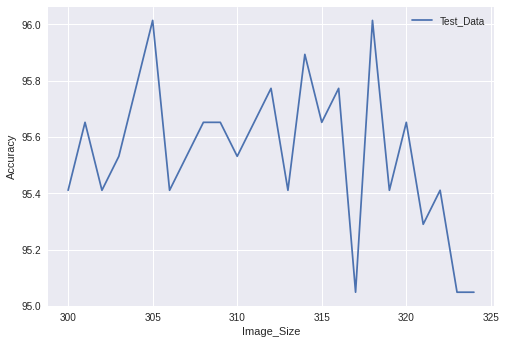

In [19]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [20]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.875   | 0.913  | 0.894 |          |
|  bcc   |   0.8214  | 0.885  | 0.852 |          |
|  bkl   |   0.8286  | 0.879  | 0.853 |          |
|   df   |    0.8    | 0.667  | 0.727 |          |
|  mel   |   0.8462  | 0.647  | 0.733 |          |
|   nv   |   0.9895  | 0.991  |  0.99 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9601  |
+--------+-----------+--------+-------+----------+


In [21]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

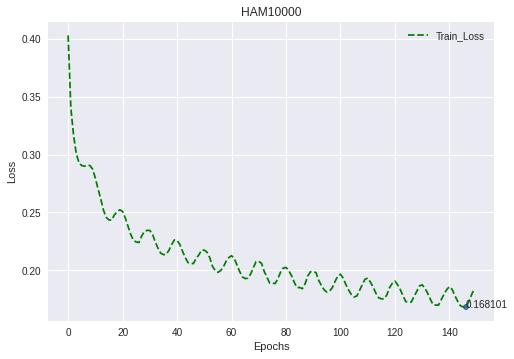

In [22]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

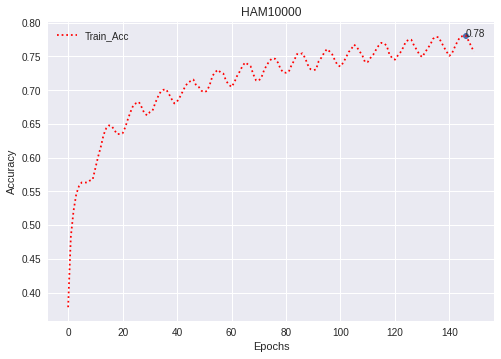

In [23]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

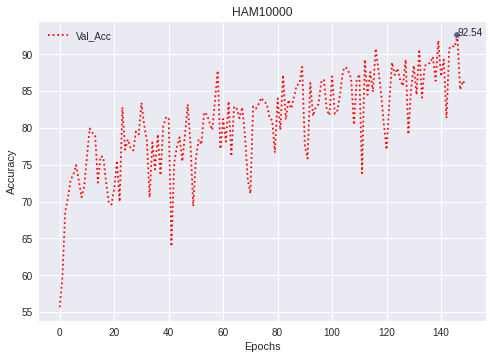

In [24]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

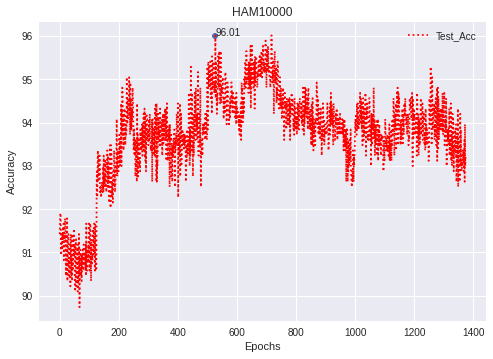

In [25]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [26]:
torch.cuda.memory.empty_cache()

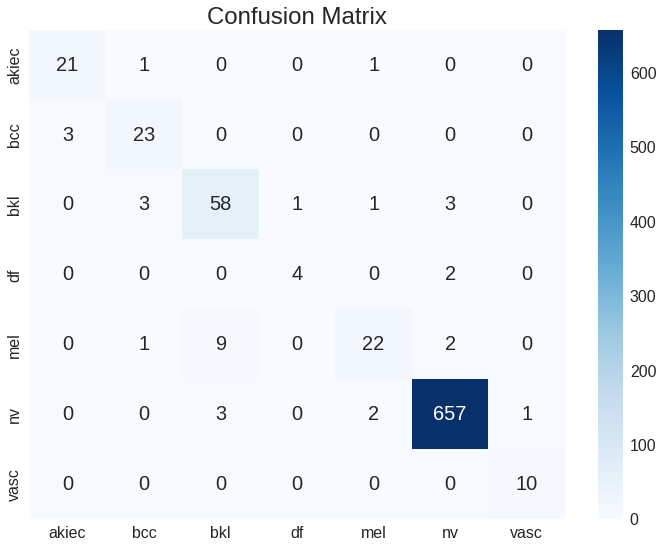

In [27]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)